# Setup tensorflow object detection and verify

In [ ]:
!git clone https://github.com/tensorflow/models.git
%cd models/research/

# From within TensorFlow/models/research/
!protoc object_detection/protos/*.proto --python_out=.

!pip install cython

# From within TensorFlow/models/research/
!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

# From within TensorFlow/models/research/
!python object_detection/builders/model_builder_tf2_test.py

In [ ]:
!cp -rf /content/drive/MyDrive/pollinator_detection/* .

In [ ]:
!python object_detection/model_main_tf2.py --pipeline_config_path=model.config --model_dir=my_model --alsologtostderr

In [ ]:
!cp -rf /content/models/research/my_model /content/drive/MyDrive/pollinator_detection/

In [ ]:
!python object_detection/exporter_main_v2.py --input_type image_tensor --pipeline_config_path model.config --trained_checkpoint_dir my_model/ --output_directory exported_model

In [20]:
!cp -rf exported_model /content/drive/MyDrive/pollinator_detection

In [9]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [10]:
PATH_TO_MODEL_DIR = 'exported_model'
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 37.69089674949646 seconds


In [13]:
import os
PATH_TO_LABELS = 'data/label_map.pbtxt'
root_dir = "/content/drive/MyDrive/pollinator_detection/test_images"
imgs = os.listdir(root_dir)
IMAGE_PATHS = [os.path.join(root_dir, x) for x in imgs]
print(IMAGE_PATHS)

['/content/drive/MyDrive/pollinator_detection/test_images/motion_2021-06-08_05_42_36_89_mp4-19_jpg.rf.4a4853b06da64cb4a4f8b3899ddd2837.jpg', '/content/drive/MyDrive/pollinator_detection/test_images/motion_2021-06-08_08_34_38_334_mp4-16_jpg.rf.64beb5ae2811d3ad19637cfcae83970b.jpg', '/content/drive/MyDrive/pollinator_detection/test_images/motion_2021-06-17_22_39_36_172_mp4-141_jpg.rf.5e7d765dd34ec6f79d1b2c385c6eac68.jpg', '/content/drive/MyDrive/pollinator_detection/test_images/motion_2021-07-05_15_20_13_165_mp4-17_jpg.rf.d219d9be0e1f91aed51f075d4b0ccce8.jpg', '/content/drive/MyDrive/pollinator_detection/test_images/motion_2021-07-07_13_33_20_21_mp4-251_jpg.rf.37bebeab29ba4471b9cb82a6bf83a6a8.jpg']


Running inference for /content/drive/MyDrive/pollinator_detection/test_images/motion_2021-06-08_05_42_36_89_mp4-19_jpg.rf.4a4853b06da64cb4a4f8b3899ddd2837.jpg... Done
Running inference for /content/drive/MyDrive/pollinator_detection/test_images/motion_2021-06-08_08_34_38_334_mp4-16_jpg.rf.64beb5ae2811d3ad19637cfcae83970b.jpg... Done
Running inference for /content/drive/MyDrive/pollinator_detection/test_images/motion_2021-06-17_22_39_36_172_mp4-141_jpg.rf.5e7d765dd34ec6f79d1b2c385c6eac68.jpg... Done
Running inference for /content/drive/MyDrive/pollinator_detection/test_images/motion_2021-07-05_15_20_13_165_mp4-17_jpg.rf.d219d9be0e1f91aed51f075d4b0ccce8.jpg... Done
Running inference for /content/drive/MyDrive/pollinator_detection/test_images/motion_2021-07-07_13_33_20_21_mp4-251_jpg.rf.37bebeab29ba4471b9cb82a6bf83a6a8.jpg... Done


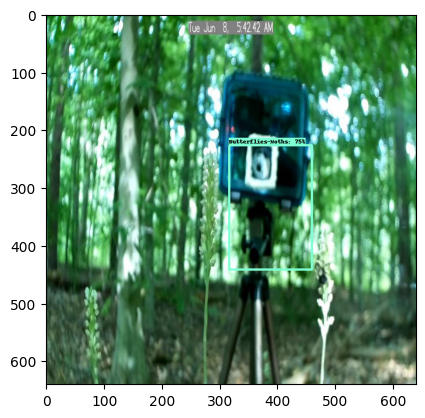

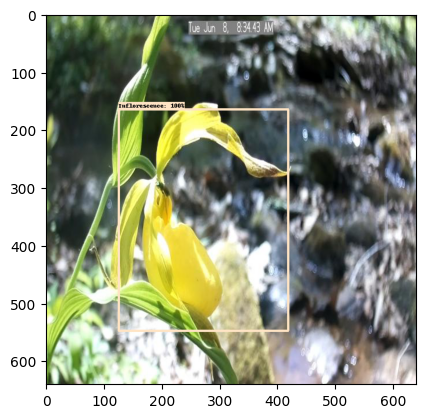

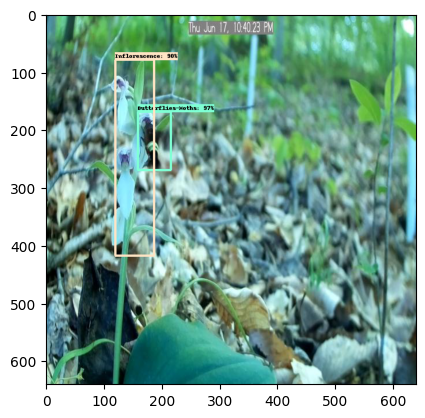

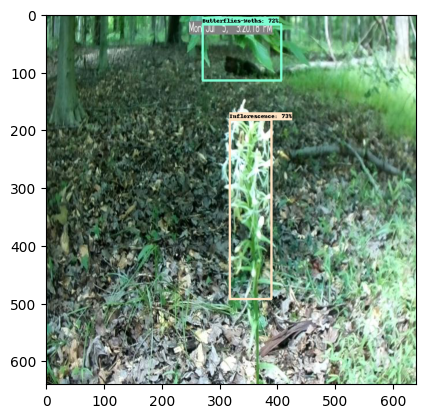

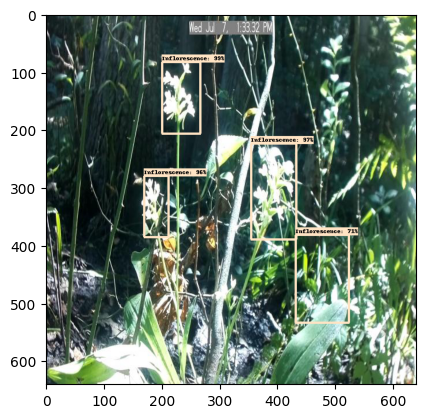

In [19]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections = detect_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.70,
          agnostic_mode=False)

    plt.figure()
    plt.imshow(image_np_with_detections)
    print('Done')
plt.show()